In [1]:
import pandas as pd
import numpy as np
import sklearn
import nltk
import re
import os
import codecs
import mpld3
import matplotlib.pyplot as plt
import seaborn
from time import time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

# Load data and pick a sample of 10%
data = pd.read_pickle("darklyrics/clean_word_lyrics.pkl")
#data = pd.read_pickle("darklyrics/stemmed_lyrics.pkl")
#data = data.sample(frac=0.1)

In [18]:
data['lyrics_string'].iloc[1]

u'somewhere near empty space inauspicious fruit fell ground birth took meaning beginning finished end nothing began look yellow leaves sleeping annihilation sound like notes silent full ambiguity glance child hot desert cold meaningless calmness voice hidden graves clapper claw reach death secret neatness whiteness time abstruse sick prism beauty abomination black lines regret innocent walls burning flaws without look proceeding deep human look castlein remembrance humanity swear cunning adorations existence adorations unfetter battle water fire battle blood darkness end doesnt end without good bad altitude fallannihilation open eyes sky seems nothing standing deep castle might assumption black tired hearts hail eternity endless yearseternal darkness new ageage justicethe age darkness blood age cursed lifeand empty age darkness flies sky angels fall salvation dies nothing remains day god death comes joy begins pain suffer praying anti christmuhammad ibrahim lie dies truth packs nothing

## Counting distribution of words

In [5]:
from sklearn.feature_extraction.text import CountVectorizer
word_vectorizer = CountVectorizer()
count_sparse_matrix = word_vectorizer.fit_transform(data['lyrics_string'])
frequencies = sum(count_sparse_matrix).toarray()[0]
count_df = pd.DataFrame(frequencies, index=word_vectorizer.get_feature_names(), columns=['frequency'])
count_df.head()

,frequency
00,5
000,41
000049,1
000528,1
0010110,1


In [6]:
total_words = count_df['frequency'].sum()
count_df['frequency_p'] = count_df['frequency'] / float(total_words) * 100.0
labels = [str(x) for x in range(1, 101)]
labels.insert(0, '1 doc')
percentage_counts = []

for x in range(1, 101):
    percentage_counts.append(len(count_df[ (count_df.frequency_p >= x - 1) & (count_df.frequency_p < x) ]))
    
single_doc_count = len(count_df[count_df.frequency == 1])
percentage_counts[0] -= single_doc_count
percentage_counts.insert(0, single_doc_count)
print labels
print percentage_counts

['1 doc', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100']
[141908, 123526, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


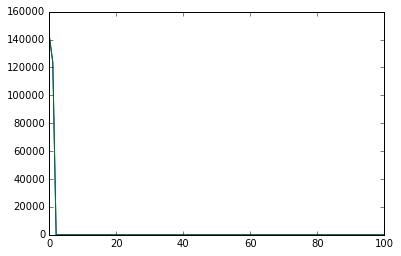

In [10]:
plt.plot(percentage_counts)
#plt.axis(labels)
plt.show()

## Stemming

In [3]:
from nltk.stem.snowball import SnowballStemmer

stemmer = SnowballStemmer("english")

def stem_text(text, stemmer):
    return ' '.join([stemmer.stem(word) for word in text.split()])

data['lyrics_string'] = data.lyrics_string.apply(lambda x: stem_text(x, stemmer))

In [5]:
# Save stemmed vocabulary in file
data.to_pickle("darklyrics/stemmed_lyrics.pkl")


In [16]:
begin = time()
vectorizer = TfidfVectorizer(ngram_range=(1, 1))
x = vectorizer.fit_transform(data['lyrics_string'])
end = time()
print 'TFIDF vectorization performed in %f seconds' % (end - begin)
print 'Num samples: %d, num features: %d' % x.shape

TFIDF vectorization performed in 17.759473 seconds
Num samples: 189123, num features: 265434


### Results of stemming vs no stemming

**Documents:** 189123

#### Stemmed

##### Unigrams only
**Time:** 84.3s
**Features:** 208631

##### Bigrams
**Time:** 
**Features:** 

##### Trigrams
**Time:** 
**Features:** 

#### Non-stemmed

##### Unigrams only
**Time:** 19.77s
**Features:** 102682

##### Bigrams
**Time:** 104.71
**Features:** 1546712

##### Trigrams
**Time:** 
**Features:** 


In [17]:
features = vectorizer.get_feature_names()

def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

def top_feats_in_doc(Xtr, features, row_id, top_n=25):
    ''' Top tfidf features in specific document (matrix row) '''
    row = np.squeeze(Xtr[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

tfidf_sample = top_feats_in_doc(x, features, 1)
tfidf_sample

,feature,tfidf
0,adorations,0.273468
1,darkness,0.234321
2,age,0.173305
3,christmuhammad,0.147590
4,justicethe,0.147590
5,fallannihilation,0.147590
6,castlein,0.147590
7,ibrahim,0.147590
8,ageage,0.147590
9,yearseternal,0.147590


In [ ]:


km = KMeans(n_clusters=50)
begin = time()
km.fit(x)
end = time()
print 'K means computed in %f' % (end - begin)